# Credit Card Fraud Classification - Toby Liang

## I. Import Essential Libraries

In [1]:
# Arrays and dataframes
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## II. Introducing the Data

In [2]:
# Import the data
path = "./data/credit_card.csv"
dataset = pd.read_csv(path)

# Renaming columns
columns = []
for col in dataset.columns:
    columns.append(col.lower())
columns[-1] = "label"
dataset.columns = columns

# Shape of dataset
print("Number of examples: {}\nNumber of variables: {}".format(dataset.shape[0], dataset.shape[1]))

# Checking for number of unique labels
print("Unique Labels: {}\n".format(dataset.label.unique()))

# Printing first 5 rows
dataset.head()

Number of examples: 284807
Number of variables: 31
Unique Labels: [0 1]



,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


We have 284,807 examples with 31 columns.  There are two unique labels in the dataset, meaning that this is a binary classification problem.

## III. Exploratory Data Analysis, Data Cleaning, and Data Transformation

### 1. Missing Values Imputation

In [3]:
# Checking for NaN values
has_nan_vars = []
for var, nan_count in (dataset.isnull().sum()).items():
    if (nan_count != 0):
        has_nan_vars.append({var: nan_count})
        
# Checking for 0 values
has_zero_vars = []
for var, zero_count in ((dataset == 0).astype(int).sum()).items():
    if(zero_count != 0):
        has_zero_vars.append({var: zero_count})
        
print("Variables with NaN values: {}".format(has_nan_vars))
print("Variables with zero values: {}".format(has_zero_vars))

Variables with NaN values: []
Variables with zero values: [{'time': 2}, {'amount': 1825}, {'label': 284315}]


In [4]:
# Count entries that have a 0 value for amount and is fraudulent
print("Fraudulent zero amount count: {}".format(((dataset.amount == 0).astype(int) & (dataset.label == 1)).sum()))

# Count entries that have a 0 value for amount and is not fraudulent
print("Non-fraudulent zero amount count: {}".format(((dataset.amount == 0).astype(int) & (dataset.label == 0)).sum()))

Fraudulent zero amount count: 27
Non-fraudulent zero amount count: 1798


No features have NaN values.  The only features that have zero values are time and amount.  Time is the amount of time in seconds after the first transaction which can be zero if the transactions occur at the same time.  Amount is the amount of money involved in a transaction.  27 entries have a 0 transaction amount and is fraudulent.

In [5]:
# Remove 0 amount transactions
copy_dataset = dataset.drop(dataset[dataset["amount"] == 0].index)
mean = copy_dataset["amount"].mean()
dataset["amount"].mask(dataset["amount"] == 0, mean, inplace=True)

# Sanity check
print("Zero amount count: {}".format(((dataset.amount == 0).astype(int)).sum()))

Zero amount count: 0


### 2. Datatype Checking

In [6]:
# Check if features are all continuous (float64)
print("Feature Datatypes: \n{}".format(dataset.dtypes.value_counts()))

Feature Datatypes: 
float64    30
int64       1
dtype: int64


All 30 features are continuous numerical with a datatype of float64.  The label is binary and is of type int64.

### 3. Duplicate Removal

In [7]:
# Checking for duplicate rows
dataset.duplicated().value_counts()

False    283726
True       1081
dtype: int64

There are 1081 duplicate rows in the dataset.  These duplicates will have to be dropped so that there are no duplicates in the test set.

In [8]:
# Drop duplicates (Do not want duplicates in test set)
dataset.drop_duplicates(inplace=True)

# Duplicate drop sanity check
print("Duplicates: {}".format(dataset.duplicated().sum()))

Duplicates: 0


### 4. Univariate Analysis

In [9]:
# Feature description
dataset.describe().round(2)

,time,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v21,v22,v23,v24,v25,v26,v27,v28,amount,label
count,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00,...,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00,283726.00
mean,94811.08,0.01,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,...,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,89.04,0.00
std,47481.05,1.95,1.65,1.51,1.41,1.38,1.33,1.23,1.18,1.10,...,0.72,0.72,0.62,0.61,0.52,0.48,0.40,0.33,250.30,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,...,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.01,0.00
25%,54204.75,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,...,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.99,0.00
50%,84692.50,0.02,0.06,0.18,-0.02,-0.05,-0.28,0.04,0.02,-0.05,...,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.94,0.00
75%,139298.00,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,...,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,79.95,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,...,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


0    283253
1       473
Name: label, dtype: int64


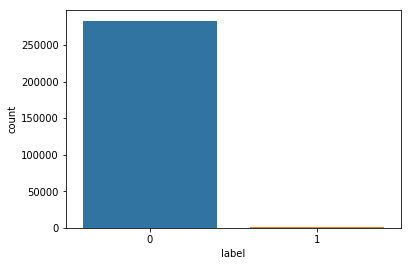

In [10]:
# Label counts
print(dataset.label.value_counts())
sns.countplot(dataset.label)
plt.show()

In this dataset, there are significantly more nonfradulent data, making this an imbalanced dataset.  Though most of the data has a mean of 0 (except for time, amount, and label), the standard deviation is not 1.  Thus, the data is not already standardized.  Additionally, the data includes values that are extremely far from the mean, especially in v6 and v7.

### 5. Train Test Splitting

In [11]:
from sklearn.model_selection import train_test_split

train_features, test_features, train_labels, test_labels = train_test_split(dataset.drop("label", axis = 1), dataset[["label"]], test_size = 0.1)

### 6. Feature Scaling

In [12]:
from sklearn.preprocessing import StandardScaler

# Initialize scaler and computer training mean and std
scaler = StandardScaler()
scaler.fit(train_features)

# Normalize the training and testing features using training mean and std
train_features = pd.DataFrame(scaler.transform(train_features), columns = train_features.columns)
test_features = pd.DataFrame(scaler.transform(test_features), columns = test_features.columns)

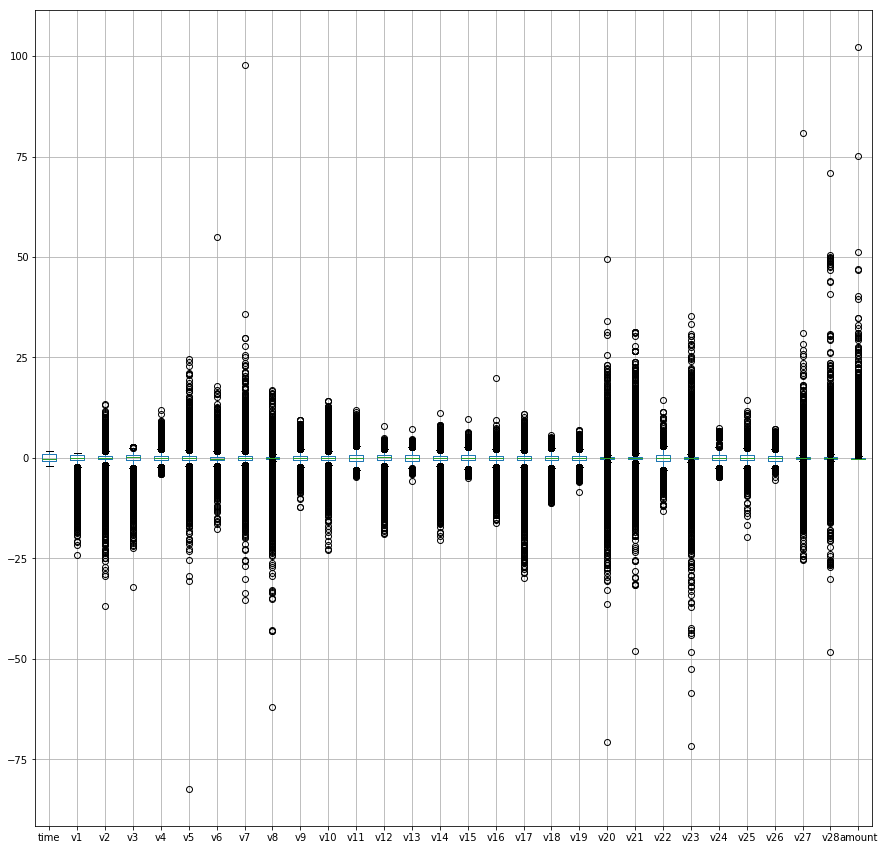

In [13]:
train_features.boxplot(figsize = (15,15))
plt.show()

### 6. Resampling

In [14]:
from sklearn.utils import resample

# Concatenate features and labels for train set
train_dataset = pd.concat([train_features, train_labels], axis = 1)

# Get non_fraud and fraud data
not_fraud_dataset = train_dataset[train_dataset.label == 0]
fraud_dataset = train_dataset[train_dataset.label == 1]

def undersample(not_fraud_dataset, fraud_dataset):
    # Undersample not_fraud
    not_fraud_undersampled = resample(not_fraud_dataset, replace = True, n_samples = len(fraud_dataset))
    
    # Concatenate undersampled not_fraud with fraud
    train_dataset_undersampled = pd.concat([not_fraud_undersampled, fraud_dataset])
    
    return train_dataset_undersampled

def oversample(not_fraud_dataset, fraud_dataset):
    # Oversample fraud
    fraud_oversampled = resample(fraud_dataset, replace = True, n_samples = len(not_fraud_dataset))
    
    # Concatenate oversampled fraud with not_fraud
    train_dataset_oversampled = pd.concat([fraud_oversampled, not_fraud_dataset])
    
    return train_dataset_oversampled

In [15]:
train_dataset_resampled = undersample(not_fraud_dataset, fraud_dataset)
train_features_resampled = train_dataset.drop("label", axis = 1)
train_labels_resampled = train_dataset["label"]

1.0    422
0.0    422
Name: label, dtype: int64


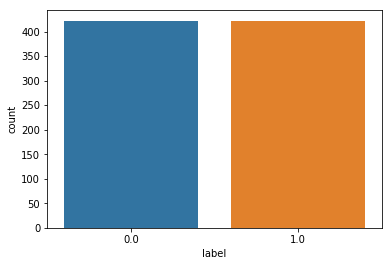

In [16]:
# Resampled label counts
print(train_dataset_resampled.label.value_counts())
sns.countplot(train_dataset_resampled.label)
plt.show()

### 7. Bivariate Analysis

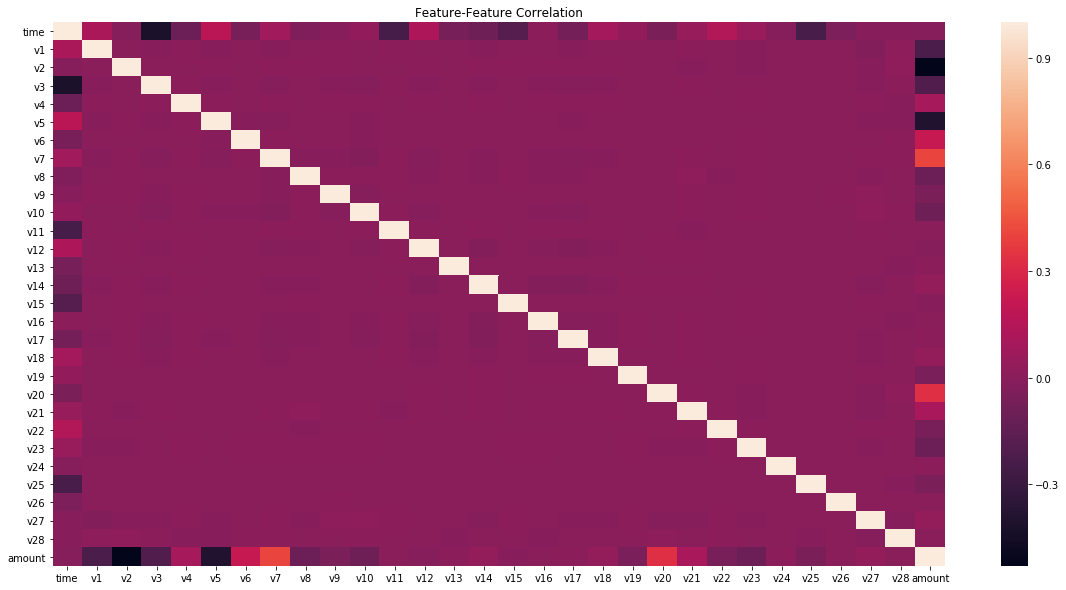

In [17]:
# Feature-feature correlation heatmap
plt.figure(figsize=(20, 10))
plt.title("Feature-Feature Correlation")
sns.heatmap(train_features_resampled.corr())
plt.show()

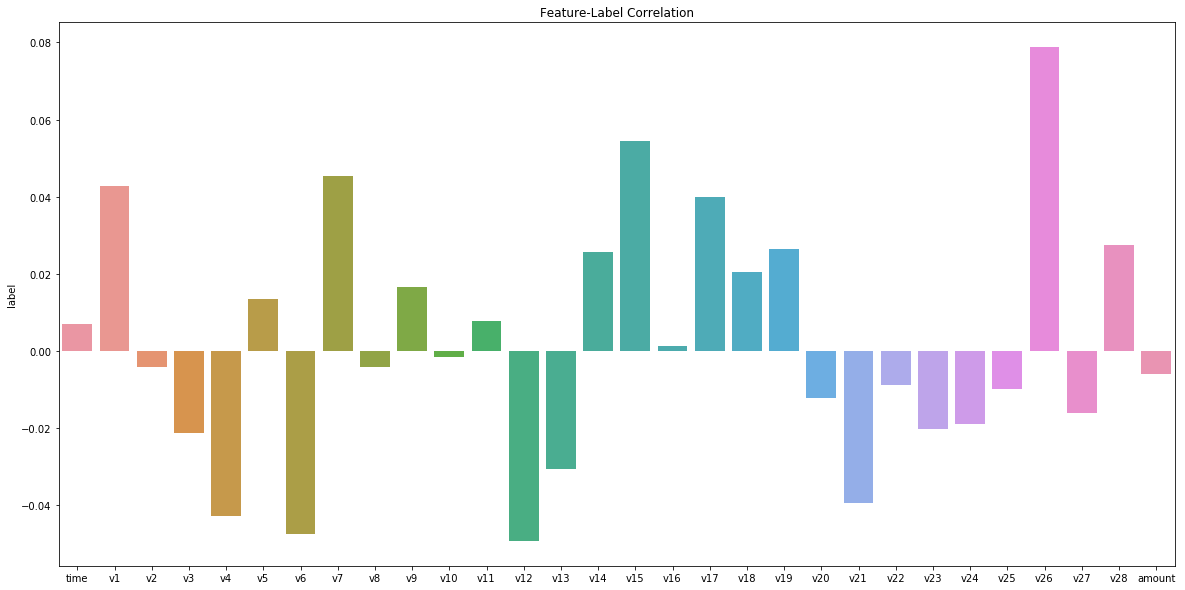

In [18]:
# Feature-label correlation barplot
plt.figure(figsize=(20, 10))
plt.title("Feature-Label Correlation")
sns.barplot(train_features_resampled.columns, train_dataset_resampled.corr()["label"].iloc[:-1])
plt.show()

### 8. Outlier Treatment

In [19]:
# Find interquartile range
q1 = train_dataset_resampled.quantile(0.25)
q3 = train_dataset_resampled.quantile(0.75)
iqr = q3 - q1

# Consolidate dataset indexes
train_dataset_resampled.reset_index(drop=True, inplace=True)

# Detect outliers
outlier_index = train_dataset_resampled[(train_dataset_resampled < q1 - 1.5 * iqr) | (train_dataset_resampled > q3 + 1.5 * iqr)].dropna(how="all").index
outliers = train_dataset_resampled.iloc[outlier_index.to_list()]

In [20]:
outliers["label"].value_counts()

1.0    186
0.0    185
Name: label, dtype: int64